In [1]:
!pip install Bunch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal 
from scipy import stats
from bunch import Bunch
import itertools
import seaborn as sns
import statsmodels.api as sm
import pywt

%matplotlib inline
plt.rcParams.update({'font.size': 12})

In [2]:
def ridge_error(x,y, r=0):
    ''' ridge_error(x,y, lambda):
    predicts y [N by m] from x [N by p] by ridge regression. 
    
    Returns:
    * fit error as a frac of variance (scalar), 
    * weight [p by m], 
    * prediction [N by m].'''
    
    # append to bottom of matrices to make ridge regression
    n = x.shape[0]
    p = x.shape[1]
    m = y.shape[1]
    x0 = np.block([[x, np.ones([n,1])]])
    x1 = np.block([[x, np.ones([n,1])], [r*np.eye(p), np.zeros([p,1])]])
    y1 = np.block([[y],[np.zeros((p,m))]])
    w,_,_,_ = np.linalg.lstsq(x1,y1, rcond=None)
    yhat = x0@w
    return np.mean((y-yhat)**2)/np.var(y), w, yhat

#ridge_error(np.array([[1],[0]]),np.array([[2],[1]]),1e10)

In [3]:
# parameters for noise process with block target
paramsB = Bunch(
    T = 200, # number of trials
    C = 10,# number of cells
    ex = 0, # sd of amplitude of exponential components in sources
    exp_tc = 15, # time constant of the exponentional components
    nx = 0.1, # amp of colored noise in sources
    tx = 0, #sd of amplitude of target in sources
    wx = 0, #sd of white noise in sources
    shift_rate = 2, # expected number of shifts during the recording, for each cell
    shift_width = 10, # width of shifts
    target_noise = False, # if true, target is pink noise series rather than blocks
    target_shift_amp = 1, # add a random shift component to target, with this amplitude (only if noise)
    signal_f_tc = False, # filter target with this timecourse before adding to x. False:don't
    bl = 50, # target block length, if target is blocks
    blrand = 20, # block length add random between 0 and this
    tau = 5000.0, # time constant of pink noise (trials)
    noise_nonlin = 1, # apply this power to the noise signal to make a nonlinear time series. 1 means linear
    blocks_stationary = False # shift blocks randomly to make them stationary?
)

#with noise target
paramsN = Bunch(paramsB)
paramsN.target_noise=True

#with actual predictability
paramsB1 = Bunch(paramsB)
paramsB1.tx = .1
paramsN1 = Bunch(paramsN)
paramsN1.tx = 1

paramList = (paramsB, paramsN, paramsB1, paramsN1)
nParams = len(paramList)

Seed = 5
R = 1000 # number of repeats
N = 500 # number of resamples for p value

def make_shift_sequence(T,C,rate,width,pad=1):
    ''' make a timeseries of logistic shifts occuring at poisson times, of +-1 amplitude 
    (T,C): output size. rate: expected number of shifts per cell. width: logistic width
    pad(=1): what multiple of window to subset from (to make stationary)'''
    
    long_seq = np.zeros((pad*T,C))
    for c in range(C):
        shift_times = np.random.choice(pad*T,np.random.poisson(rate*pad))
        for t in shift_times:
            sign = np.sign(np.random.rand(1)-.5)
            long_seq[:,c] += 1/(1+np.exp(sign*(np.arange(pad*T)-t)/width))
    return long_seq[T*(pad-1)//2 : T*(pad+1)//2 ]

def make_data(params):
    ''' returns x, y
    x: T by C array of analog signals [pink noise + exponential drift + linear + target]
    y: target signal: binary block or another noise'''

    # weights for each cell
    expwt = params.ex * np.random.randn(params.C) 
    ywt = params.tx * np.random.randn(params.C)
    

    #parameters for filtered noise
    alpha = np.exp(-2.0/params.tau)
    b = np.array([np.sqrt(1-alpha)])
    a = np.array([1, -np.sqrt(alpha)])
    
    # make filtered noise
    x0,_ =  signal.lfilter(b,a, np.random.randn(params.T,params.C), axis=0, zi=np.random.randn(1,params.C)) 
    
     
    x = params.nx*(x0**params.noise_nonlin) \
        + expwt[None,:] * np.exp(-np.arange(params.T)[:,None]/params.exp_tc) \
        + params.wx * np.random.randn(params.T, params.C) \
        + make_shift_sequence(params.T, params.C, params.shift_rate, params.shift_width)
        
    if params.target_noise:
        y0,_ =  signal.lfilter(b,a, np.random.randn(params.T,1), axis=0, zi=np.random.randn(1,1)) 
        y = params.nx*(y0**params.noise_nonlin) \
            +make_shift_sequence(params.T, 1, params.shift_rate, params.shift_width)
    else: 
        #make blocks
        nBlx = 1000 # way too many blocks, because we might randomize from it
        blockLen = np.random.randint(params.bl, params.bl+params.blrand, nBlx)
        flipTimes = np.cumsum(blockLen)
        y0 = np.cumsum(np.bincount(flipTimes, (-1)**np.arange(nBlx)))


        if params.blocks_stationary:
            startPoint = np.random.randint(len(y0)//2)
            y = y0[startPoint:startPoint+params.T,None]
        else:
            y = y0[:params.T,None]
    
    
    # now add part of target if needed
    if params.signal_f_tc:
        alpha2 = -np.exp(1.0/params.signal_f_tc)
        a2 = np.array([alpha2/(1+alpha2), 1/(1+alpha2)])  
        yf,_ = signal.lfilter([1],a2,y, axis=0, zi=-y[0,None]/alpha2)
        x += ywt[None,:] * yf
    else:
        x += ywt[None,:] * y
    
    # scale 0 to 1
    y = (y-y.min(0))/(y.max(0)-y.min(0))
    x = (x-x.min(0))/(x.max(0)-x.min(0))
    
    
    return x,y


In [4]:
# make data
# exampleData =[]
# for params in paramList:
#     np.random.seed(Seed)
#     exampleData.append(make_data(params))

testData = []
for i, params in enumerate(paramList):
    np.random.seed(Seed)
    testData.append([])
    for r in range(R):
        testData[i].append(make_data(params))

#plt.plot(testData[1][0][1])

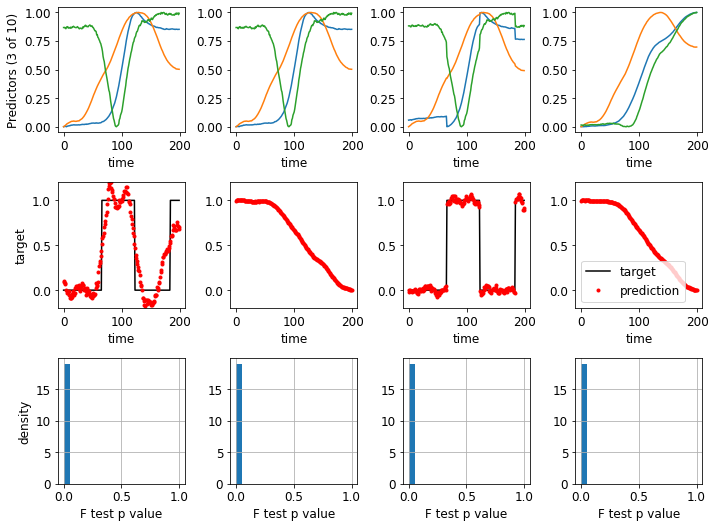

In [5]:

# p values for multiple linear regression

if 1: # make 0 to skip calculations
    p_naive = np.zeros((nParams, R))
    for i in range(nParams):
        for r in range(R):
            x,y = testData[i][r]
            model = sm.OLS(y,np.hstack((x,np.ones((params.T,1))))).fit()
            p_naive[i,r] = model.f_pvalue
        
        
fig, ax = plt.subplots(3,nParams, figsize=(10,7.5))
for i in range(nParams):
    x,y = testData[i][0]
    ax[0,i].plot(x[:,:3])
    ax[1,i].plot(y, 'k')
    _,_,yhat = ridge_error(x,y)
    ax[1,i].plot(yhat, 'r.')
    ax[1,i].set_ylim([-.2, 1.2])
    ax[2,i].hist(p_naive[i], np.linspace(0,1,20), density=True)
    ax[2,i].grid()
    ax[0,i].set_xlabel('time')
    ax[1,i].set_xlabel('time')
    ax[2,i].set_xlabel('F test p value')
    
ax[0,0].set_ylabel('Predictors (3 of %d)'%params.C)
ax[1,0].set_ylabel('target')
ax[2,0].set_ylabel('density')
ax[1,3].legend(('target', 'prediction'))

plt.tight_layout()
plt.savefig('Ftest.png',dpi=300)

pval = 0.762000
pval = 0.798000
pval = 0.000000
pval = 0.522000


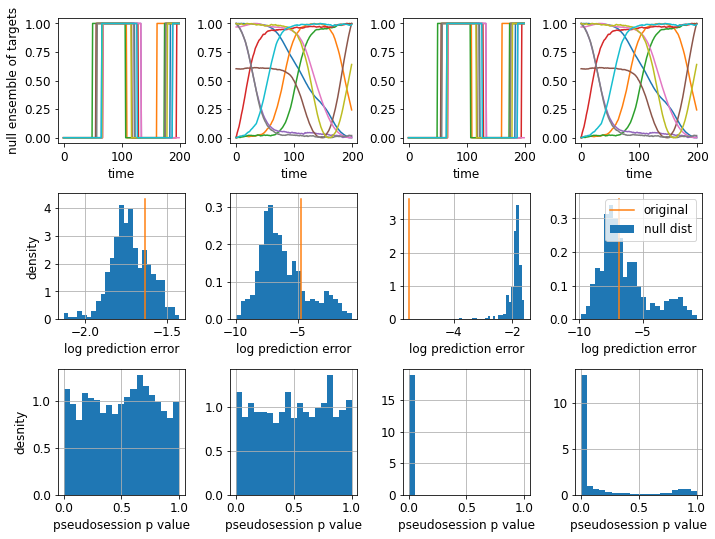

In [6]:
## pseudosession method

if 1: # make 0 to skip calculations
    p_pseudosession = np.zeros((nParams,R))
    pScore_pseud = np.zeros((nParams,N))
    uScore_pseud = np.zeros(nParams)
    for i, params in enumerate(paramList):
        np.random.seed(Seed)
        for r in range(R):
            x,y = testData[i][r]
            uScore_pseud[i],_,_ = ridge_error(x,y) # unpermuted score

            for n in range(N):
                _,y2 = make_data(params)
                pScore_pseud[i,n],_,_ = ridge_error(x,y2)
            p_pseudosession[i,r] = stats.percentileofscore(pScore_pseud[i], uScore_pseud[i])/100

fig, ax = plt.subplots(3,nParams, figsize=(10,7.5))#, sharey='row')
for i, params in enumerate(paramList):
    np.random.seed(Seed)
    for n in range(10): 
        _,y2 = make_data(params)
        ax[0,i].plot(y2)
    ax[1,i].hist(np.log(pScore_pseud[i]),25, density=True)
    ax[1,i].plot(np.full(2,np.log(uScore_pseud[i])), ax[1,i].get_ylim())
    ax[1,i].grid()

    print('pval = %f'%p_pseudosession[i,-1])
    ax[2,i].hist(p_pseudosession[i],np.linspace(0,1,20),density=True)
    ax[2,i].grid()
    ax[0,i].set_xlabel('time')
    ax[1,i].set_xlabel('log prediction error')
    ax[2,i].set_xlabel('pseudosession p value')
        
ax[0,0].set_ylabel('null ensemble of targets')
ax[1,0].set_ylabel('frequency')
ax[1,0].set_ylabel('density')
ax[2,0].set_ylabel('desnity')
ax[1,3].legend(['original', 'null dist'])
    
plt.tight_layout()
plt.savefig('Pseudosession.png',dpi=300)

data set 0
data set 1
data set 2
data set 3


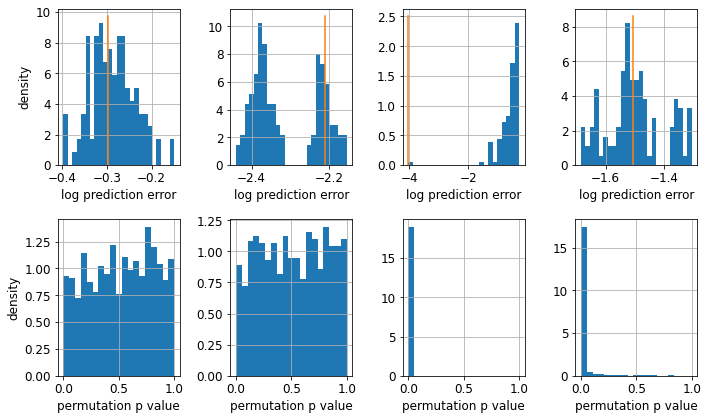

In [7]:
## Session permutation
S = 5 #number of sessions


if 1:
    np.random.seed(Seed)
        
    p_perm = np.zeros((nParams,R))
    uScore_perm = np.zeros(nParams)
    pScore_perm = np.zeros((nParams,np.math.factorial(S)))

    for i, params in enumerate(paramList):
        print('data set %d'%i)
        for r in range(R):
            x = np.empty(S,dtype=object)
            y = np.empty(S,dtype=object)

            uScore_perm[i]=0
            for s in range(S):
                x[s],y[s] = make_data(params)
                sc,_,_ = ridge_error(x[s],y[s],0)
                uScore_perm[i] += sc

            pScore_perm[i]=0
            for j,p in enumerate(itertools.permutations(range(S))):
                for s in range(S):
                    sc,_,_ = ridge_error(x[s],y[p[s]],0)
                    pScore_perm[i,j] += sc

            p_perm[i,r]=stats.percentileofscore(pScore_perm[i], uScore_perm[i])/100
        
fig, ax = plt.subplots(2,len(paramList), figsize=(10,6))
for i in range(nParams):
    ax[0,i].hist(np.log(pScore_perm[i]),25, density=True)
    ax[0,i].plot(np.full(2,np.log(uScore_perm[i])), ax[0,i].get_ylim())
    ax[0,i].grid()
    ax[1,i].hist(p_perm[i],np.linspace(0,1,20), density=True)
    ax[1,i].grid()
    ax[0,i].set_xlabel('log prediction error')
    ax[1,i].set_xlabel('permutation p value')


ax[0,0].set_ylabel('density')
ax[1,0].set_ylabel('density')

plt.tight_layout()
plt.savefig('SessionPerm.png',dpi=300)

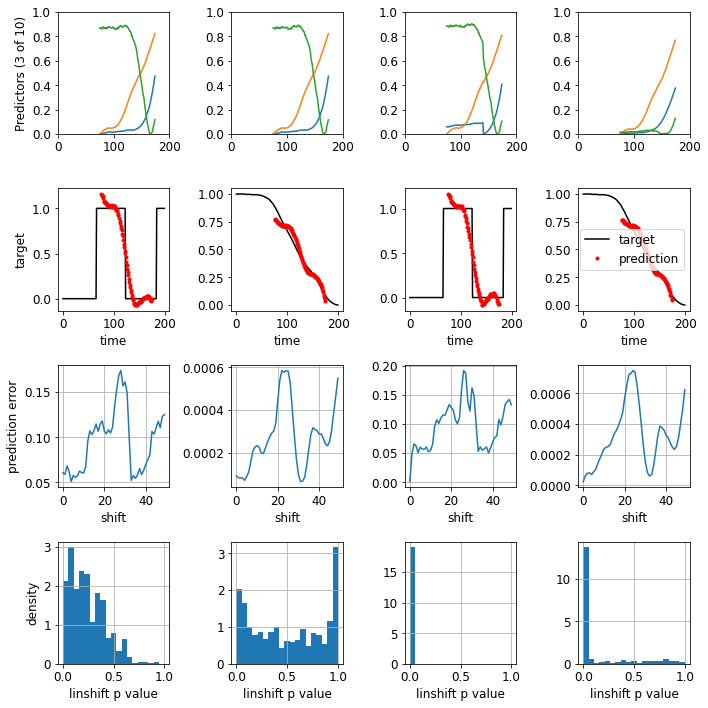

In [8]:
# linear shift test
if 1:
    p_linshift = np.zeros((nParams,R))

    step = 2
    resids = np.zeros(params.T//step//2)
    for i,params in enumerate(paramList):
        for r in range(R):
            x,y = testData[i][r]

            for shift in range(params.T//step//2):
                resids[shift],_,_ = ridge_error(x[:params.T//2],y[shift*step:shift*step+params.T//2])
            p_linshift[i,r] = stats.percentileofscore(resids, resids[0])/100


ex_shift = 75
# plots
fig, ax = plt.subplots(4,nParams, figsize=(10,10))
for i,params in enumerate(paramList):
    x,y = testData[i][0]
    subt = np.arange(ex_shift,ex_shift+params.T//2)
    subx = x[:params.T//2,:3]
    ax[0,i].plot(subt,subx)
    ax[0,i].set_xlim([0, params.T])
    ax[0,i].set_ylim([0,1])
    ax[1,i].plot(y, 'k')
    _,_,yhat = ridge_error(subx,y[subt])
    ax[1,i].plot(subt,yhat, 'r.')
    ax[1,i].set_xlabel('time')

    for shift in range(params.T//step//2):
        resids[shift],_,_ = ridge_error(x[:params.T//2],y[shift*step:shift*step+params.T//2])
    ax[2,i].plot(resids)
    ax[2,i].set_xlabel('shift')
    ax[2,i].grid()
    
    ax[3,i].hist(p_linshift[i],np.linspace(0,1,20), density=True)
    ax[3,i].grid()
    ax[3,i].set_xlabel('linshift p value')
    
ax[0,0].set_ylabel('Predictors (3 of %d)'%params.C)
ax[1,0].set_ylabel('target')
ax[1,3].legend(('target', 'prediction'))
ax[2,0].set_ylabel('prediction error')
ax[3,0].set_ylabel('density')

    
    
plt.tight_layout()
plt.savefig('LinShift.png',dpi=300)

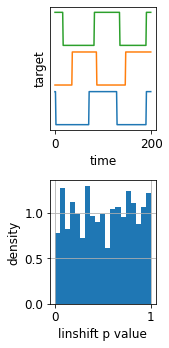

In [9]:
# linear shift test with stationarity blocks

paramsBS = paramsB
paramsBS.blocks_stationary=True

params = paramsBS

if 1:
    p_linshiftS = np.zeros((1,R))

    step = 2
    resids = np.zeros(params.T//step//2)
    for i,params in enumerate([paramsBS]):
        np.random.seed(Seed)
        for r in range(R):
            x,y = make_data(params)

            for shift in range(params.T//step//2):
                resids[shift],_,_ = ridge_error(x[:params.T//2],y[shift*step:shift*step+params.T//2])
            p_linshiftS[i,r] = stats.percentileofscore(resids, resids[0])/100

fig, ax = plt.subplots(2,1, figsize=(2.5,5))

np.random.seed(3)
for r in range(3):
    x,y = make_data(params)
    ax[0].plot(y +r*1.2)

ax[0].set_xlabel('time')
ax[0].set_ylabel('target')
ax[0].set_yticks([])
ax[1].hist(p_linshiftS[0],np.linspace(0,1,20), density=True)
ax[1].grid()
ax[1].set_xlabel('linshift p value')
ax[1].set_ylabel('density')

plt.tight_layout()
plt.savefig('LinShiftStat.png',dpi=300)

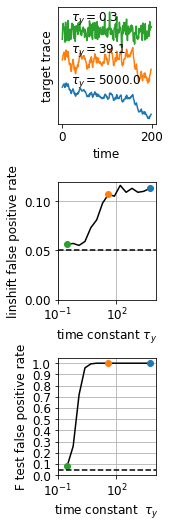

In [10]:
# effect of timeconstant on linshift


S=15 # time scales
R=1000

#fig, ax = plt.subplots(S,3, figsize=(7.5,S*2.5))

if 1:
    p_y_mix = np.zeros((S,R))
    p_F_mix = np.zeros((S,R))
    r_pearson = np.zeros((S,R))
    r_spearman = np.zeros((S,R))

    step = 2
    #for i,params in enumerate(paramList[1::2]):
    for s in np.arange(0,S):
        params = Bunch(paramsN)
        params.tau = 5000*(2.0**-s)
        params.nx *= 10000 # only noise

        np.random.seed(Seed)
        resids = np.zeros(params.T//step//2)
        for r in range(R):
            x,_ = testData[i][r]

            # make new y data
            _,y = make_data(params)

            for shift in range(params.T//step//2):
                resids[shift],_,_ = ridge_error(x[:params.T//2],y[shift*step:shift*step+params.T//2])

            r_spearman[s,r],_ = stats.spearmanr(np.arange(params.T//step//2),resids)
            r_pearson[s,r],_ = stats.pearsonr(np.arange(params.T//step//2),resids)
            p_y_mix[s,r] = stats.percentileofscore(resids, resids[0])/100

            model = sm.OLS(y,np.hstack((x,np.ones((params.T,1))))).fit()
            p_F_mix[s,r] = model.f_pvalue

fig,ax = plt.subplots(3,1, figsize=(2.5,7.5))
s_ex = np.array([0,7,14])
for s in s_ex:
    np.random.seed(Seed)
    params = Bunch(paramsN)
    params.tau = 5000*(2.0**-s)
    params.nx *= 10000 # only noise
    _,y = make_data(params)

    ax[0].plot(y+s/7)
    ax[0].text(20,s/8+1, r'$\tau_y=%.1f$'%params.tau)
ax[0].set_xlabel('time')
ax[0].set_ylabel('target trace')
ax[0].set_yticks([])


ax[1].semilogx(5000*2.**-np.arange(S),np.mean(p_y_mix<.05,axis=1), 'k')
for s in s_ex:
    ax[1].plot(5000*2.**-s,np.mean(p_y_mix[s]<.05), 'o')
ax[1].set_xlim([.1,10000])
ax[1].set_xlabel(r'time constant $\tau_y$')
ax[1].set_ylabel('linshift false positive rate')
ax[1].set_ylim(0.0)
ax[1].plot(ax[1].get_xlim(), [.05,.05], 'k--')
ax[1].set_yticks(np.arange(0,.11,.05))
ax[1].grid()

ax[2].semilogx(5000*2.**-np.arange(S),np.mean(p_F_mix<.05,axis=1), 'k')
for s in s_ex:
    ax[2].plot(5000*2.**-s,np.mean(p_F_mix[s]<.05), 'o')
ax[2].set_xlim([.1,10000])
ax[2].set_ylabel('F test false positive rate')
ax[2].set_ylim(0.0)
ax[2].plot(ax[1].get_xlim(), [.05,.05], 'k--')
ax[2].set_xlabel(r'time constant  $\tau_y$')
ax[2].set_yticks(np.arange(0,1.1,.1))
ax[2].grid()
            

plt.tight_layout()
plt.savefig('linshift_errors.png',dpi=300)
#             if r==0:
#                 ax[s,0].plot(y)
#                 ax[s,1].plot(resids)
#             #ax[r,r].title(stats.spearmanr(resids, np.arange(resids.shape[0])))
            
            
#         ax[s,2].hist(p_y_mix[s], np.linspace(0,1,20), density=True)
#         plt.draw()

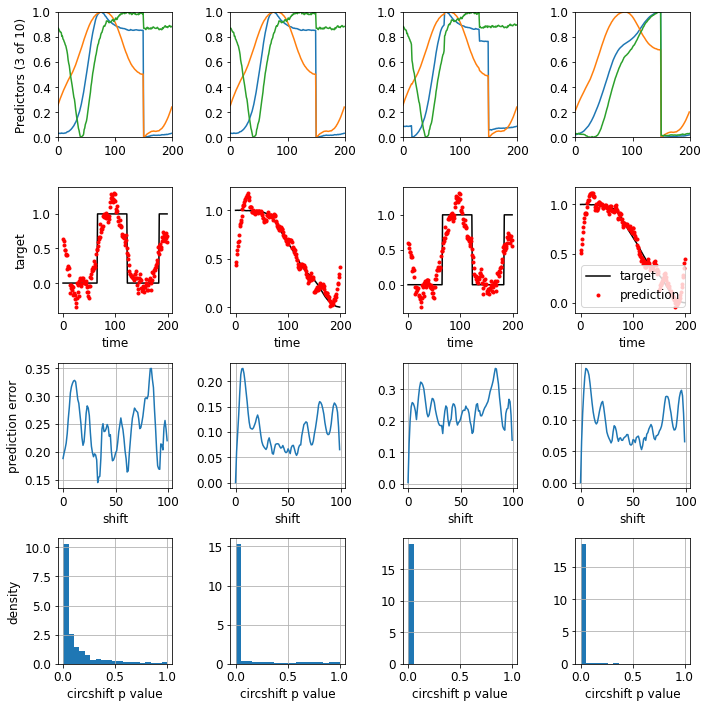

In [11]:
# circular shift test

if 1:
    p_circshift = np.zeros((nParams,R))

    step = 2
    resids = np.zeros(params.T//step)
    for i,params in enumerate(paramList):
        for r in range(R):
            x,y = testData[i][r]

            for shift in range(params.T//step):
                resids[shift],_,_ = ridge_error(np.roll(x,shift*step,0),y)
            p_circshift[i,r] = stats.percentileofscore(resids, resids[0])/100


ex_shift = 75
# plots
fig, ax = plt.subplots(4,nParams, figsize=(10,10))
for i,params in enumerate(paramList):
    x,y = testData[i][0]
    xr = np.roll(x,ex_shift*step,0)
    ax[0,i].plot(xr[:,:3])
    ax[0,i].set_xlim([0, params.T])
    ax[0,i].set_ylim([0,1])
    ax[1,i].plot(y, 'k')
    _,_,yhat = ridge_error(xr,y)
    ax[1,i].plot(yhat, 'r.')
    ax[1,i].set_xlabel('time')

    for shift in range(params.T//step):
        resids[shift],_,_ = ridge_error(np.roll(x,shift*step,0),y)
    ax[2,i].plot(resids)
    ax[2,i].set_xlabel('shift')
    ax[2,i].grid()
    
    ax[3,i].hist(p_circshift[i],np.linspace(0,1,20), density=True)
    ax[3,i].grid()
    ax[3,i].set_xlabel('circshift p value')
    
ax[0,0].set_ylabel('Predictors (3 of %d)'%params.C)
ax[1,0].set_ylabel('target')
ax[1,3].legend(('target', 'prediction'), loc='lower left')
ax[2,0].set_ylabel('prediction error')
ax[3,0].set_ylabel('density')

    
    
plt.tight_layout()
plt.savefig('CircShift.png',dpi=300)

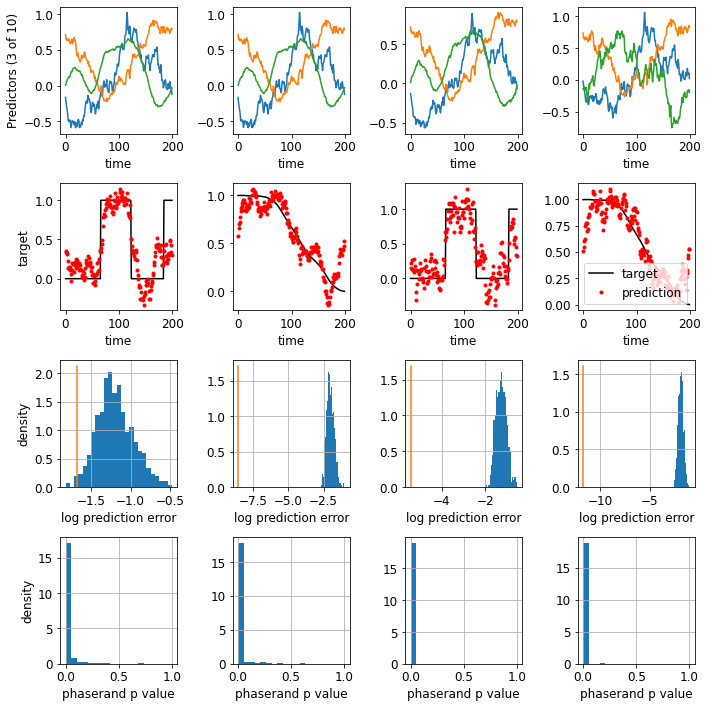

In [12]:
# phase randomization

def phaserand(x):
    xf = np.fft.rfft(x,axis=0)
    ph = np.exp(np.random.rand(*xf.shape)*2.0j*np.pi)
    return np.fft.irfft(xf*ph,axis=0) 

if 1:
    p_phaserand = np.zeros((nParams,R))


    uScore_phaserand0 = np.zeros(nParams)
    pScore_phaserand0 = np.zeros((nParams,N))
    for i,params in enumerate(paramList):
        np.random.seed(Seed)
        for r in range(R):
            x,y = testData[i][r]
            uScore,_,_ = ridge_error(x,y)

            pScore = np.zeros(N)
            for n in range(N):
                pScore[n],_,_ = ridge_error(phaserand(x),y)
            p_phaserand[i,r] = stats.percentileofscore(pScore, uScore)/100
            if r==0:
                uScore_phaserand0[i] = uScore
                pScore_phaserand0[i,:] = pScore

# plots
fig, ax = plt.subplots(4,nParams, figsize=(10,10))
for i,params in enumerate(paramList):
    np.random.seed(Seed)
    x,y = testData[i][0] # example dataset
    xr = phaserand(x)
    ax[0,i].plot(xr[:,:3])
    ax[0,i].set_xlabel('time')
    #ax[0,i].set_ylim([0,1])
    
    ax[1,i].plot(y, 'k')
    _,_,yhat = ridge_error(xr,y)
    ax[1,i].plot(yhat, 'r.')
    ax[1,i].set_xlabel('time')

    ax[2,i].hist(np.log(pScore_phaserand0[i]), 25, density=True)
    ax[2,i].plot(np.full(2,np.log(uScore_phaserand0[i])), ax[2,i].get_ylim())
    ax[2,i].set_xlabel('log prediction error')
    ax[2,i].grid()
    
    ax[3,i].hist(p_phaserand[i],np.linspace(0,1,20), density=True)
    ax[3,i].grid()
    ax[3,i].set_xlabel('phaserand p value')
    
ax[0,0].set_ylabel('Predictors (3 of %d)'%params.C)
ax[1,0].set_ylabel('target')
ax[1,3].legend(('target', 'prediction'), loc='lower left')
ax[2,0].set_ylabel('density')
ax[3,0].set_ylabel('density')
   
    
plt.tight_layout()
plt.savefig('PhaseShift.png',dpi=300)




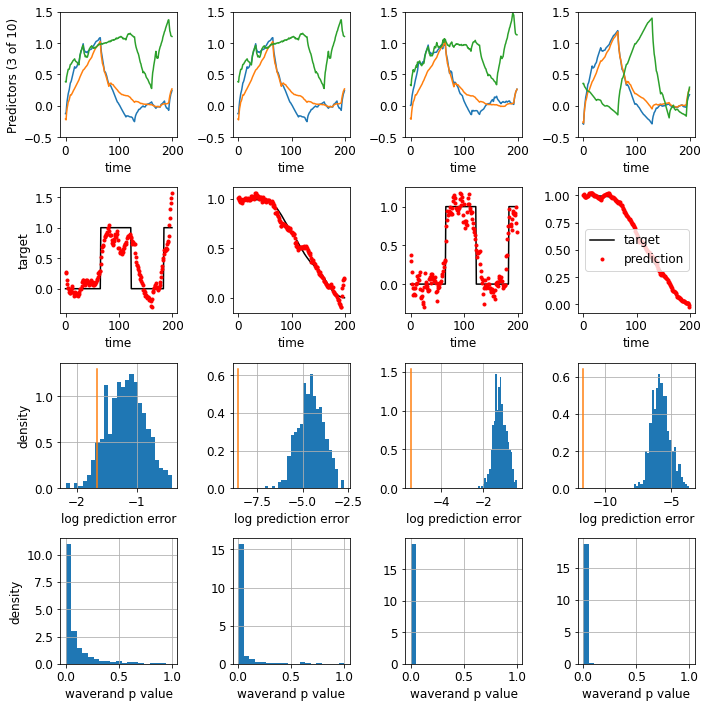

In [13]:
# wavelet randomization

def waverand(x):
    w = pywt.wavedec(x,'db2',axis=0)
    for ww in w:
        for j in range(ww.shape[1]):
            np.random.shuffle(ww[:,j])
    return pywt.waverec(w,'db2', axis=0)

if 1:
    p_waverand = np.zeros((nParams,R))

    uScore_waverand0 = np.zeros(nParams)
    pScore_waverand0 = np.zeros((nParams,N))
    for i,params in enumerate(paramList):
        np.random.seed(Seed)
        for r in range(R):
            x,y = testData[i][r]
            uScore,_,_ = ridge_error(x,y)

            pScore = np.zeros(N)
            for n in range(N):
                pScore[n],_,_ = ridge_error(waverand(x),y)
            p_waverand[i,r] = stats.percentileofscore(pScore, uScore)/100
            if r==0:
                uScore_waverand0[i] = uScore
                pScore_waverand0[i,:] = pScore

# plots
fig, ax = plt.subplots(4,nParams, figsize=(10,10))
for i,params in enumerate(paramList):
    np.random.seed(Seed)
    x,y = testData[i][0] # example dataset
    xr = waverand(x)
    ax[0,i].plot(xr[:,:3])
    ax[0,i].set_xlabel('time')
    ax[0,i].set_ylim([-.5, 1.5])

    ax[1,i].plot(y, 'k')
    _,_,yhat = ridge_error(xr,y)
    ax[1,i].plot(yhat, 'r.')
    ax[1,i].set_xlabel('time')
    
    ax[2,i].hist(np.log(pScore_waverand0[i]), 25, density=True)
    ax[2,i].plot(np.full(2,np.log(uScore_waverand0[i])), ax[2,i].get_ylim())
    ax[2,i].set_xlabel('log prediction error')
    ax[2,i].grid()
    
    ax[3,i].hist(p_waverand[i],np.linspace(0,1,20), density=True)
    ax[3,i].grid()
    ax[3,i].set_xlabel('waverand p value')
    
ax[0,0].set_ylabel('Predictors (3 of %d)'%params.C)
ax[1,0].set_ylabel('target')
ax[1,3].legend(('target', 'prediction'))
ax[2,0].set_ylabel('density')
ax[3,0].set_ylabel('density')
   
    
plt.tight_layout()
plt.savefig('Waverand.png',dpi=300)


In [14]:
# functions for cross validation

def CrossValIter(x,y, test, train=None, plot=False):
    ''' given a training and test set, compute cross-val error for one iteration
    x: source signals, T by C
    y: target signals, T by 1
    test: test set samples
    train: train set samples (default or None: whatever is not in test)
    plot: say which axis to plot on (False means no plots)
    returns error of this iteration
    '''
    T = x.shape[0]
    if train is None:
        train = np.setdiff1d(np.arange(T),test)

    x1 = np.block([[x, np.ones([T,1])]])

    _,w,pred_train = ridge_error(x[train],y[train],0)
    pred_test = x1[test]@w

    score = np.sum((y[train].mean(0) - y[test])**2) -np.sum((pred_test-y[test])**2)
    
    if plot:
        plot.plot(y, 'b')
        plot.plot(test,np.ones_like(test)*np.mean(y[train]), 'k.')
        plot.plot(train,pred_train, 'g.')
        plot.plot(test,pred_test, 'r.')
        
    return score
    
def CrossVal(x,y,K,plot=False, order=None):
    T = x.shape[0]
    if order is None:
        order = np.arange(T)
        
    score = 0
    
    for k in np.arange(K):
        test = np.arange(k*T//K, (k+1)*T//K)
        score += CrossValIter(x,y,order[test],plot=plot)
    
    return score/T


C:\Users\Kenneth\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


column 0: cv>0 100.000000 percent of the time
column 0: cv>0 54.000000 percent of the time
column 0: forecast>0 0.800000 percent of the time
column 1: cv>0 100.000000 percent of the time
column 1: cv>0 94.000000 percent of the time
column 1: forecast>0 81.500000 percent of the time
column 2: cv>0 100.000000 percent of the time
column 2: cv>0 97.800000 percent of the time
column 2: forecast>0 92.600000 percent of the time
column 3: cv>0 100.000000 percent of the time
column 3: cv>0 96.800000 percent of the time
column 3: forecast>0 88.500000 percent of the time


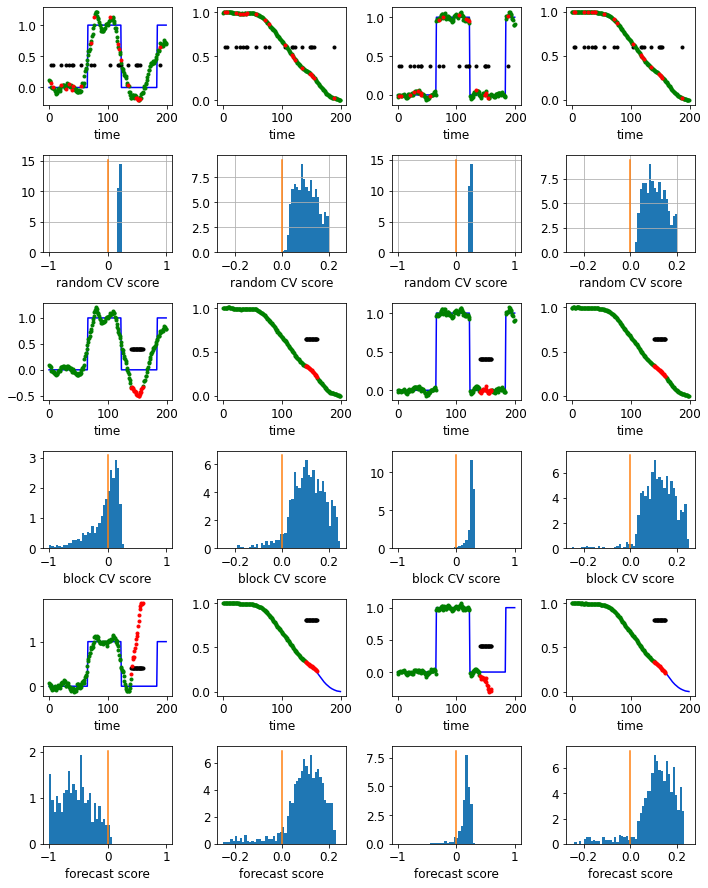

In [15]:
## cross-val plots
#cv by block
if 1:
    cv_scores = np.zeros((nParams,R))
    forecast_scores = np.zeros((nParams,R))
    ransplit_scores = np.zeros((nParams,R))
    for i, params in enumerate(paramList):
        np.random.seed(Seed)
        for r in range(R):
            x,y = testData[i][r]
            ransplit_scores[i,r] = CrossVal(x,y,10,order=np.random.permutation(params.T))
            cv_scores[i,r] = CrossVal(x,y,10)

            for k in range(1,10):
                forecast_scores[i,r] += CrossValIter(x,y,train=np.arange(k*params.T//10), 
                                                   test=np.arange(k*params.T//10, (k+1)*params.T//10),plot=False)
            forecast_scores[i,r]/=params.T
            
            
xls = [1, .25, 1, .25]

fig, ax = plt.subplots(6,nParams, figsize=(10,12.5))
for i,params in enumerate(paramList):
    x,y = testData[i][0]
    
    np.random.seed(Seed)
    order = np.random.permutation(params.T)
    CrossValIter(x,y,order[:params.T//10], plot=ax[0,i])
    ax[0,i].set_xlabel('time')
    ax[1,i].hist(ransplit_scores[i], 50, range=[-xls[i], xls[i]], density=True);
    ax[1,i].grid()
    ax[1,i].plot([0,0], ax[1,i].get_ylim())
    ax[1,i].set_xlabel('random CV score')
    
    CrossValIter(x,y,np.arange(7*params.T//10, 8*params.T//10),plot=ax[2,i])
    ax[2,i].set_xlabel('time')
    ax[3,i].hist(cv_scores[i], 50, range=[-xls[i], xls[i]], density=True);
    ax[3,i].grid()
    ax[3,i].set_xlabel('block CV score')
    ax[3,i].grid()
    ax[3,i].plot([0,0], ax[3,i].get_ylim())

    CrossValIter(x,y,train=np.arange(7*params.T//10), test=np.arange(7*params.T//10, 8*params.T//10),plot=ax[4,i])
    ax[4,i].set_xlabel('time')
    ax[5,i].hist(forecast_scores[i], 50, range=[-xls[i], xls[i]], density=True);
    ax[5,i].grid()
    ax[5,i].set_xlabel('forecast score')
    ax[5,i].grid()
    ax[5,i].plot([0,0], ax[5,i].get_ylim())
    
    print('column %d: cv>0 %f percent of the time'%(i,np.mean(ransplit_scores[i]>0)*100))
    print('column %d: cv>0 %f percent of the time'%(i,np.mean(cv_scores[i]>0)*100))
    print('column %d: forecast>0 %f percent of the time'%(i,np.mean(forecast_scores[i]>0)*100))


plt.tight_layout()
plt.savefig('CrossVal.png',dpi=300)


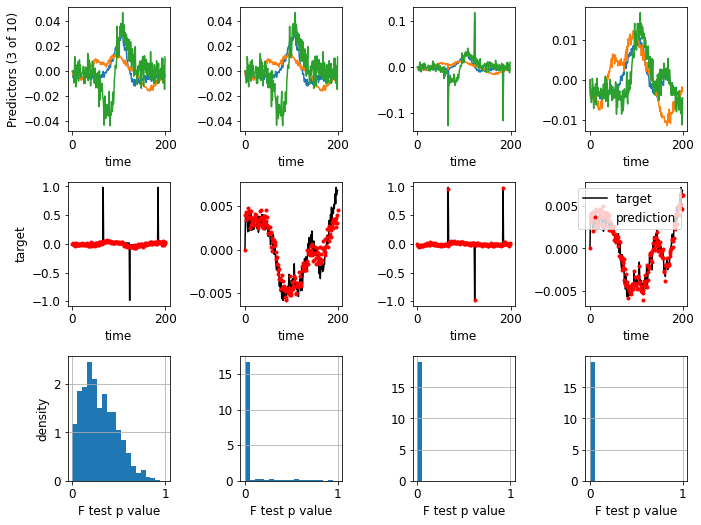

In [16]:
# F test with autoregressive

def AR1_resid(x):
    out = np.zeros_like(x)
    for i in range(x.shape[1]):
        xl = np.column_stack((x[0:-1,i], np.ones((x.shape[0]-1))))
        xt = x[1:,i]
        wts,_,_,_ = np.linalg.lstsq(xl,xt, rcond=-1)
        out[1:,i] = xt-xl@wts
    return out

if 1: # make 0 to skip calculations
    p_AR = np.zeros((nParams, R))
    for i in range(nParams):
        for r in range(R):
            x,y = testData[i][r]
            xr = AR1_resid(x)
            yr = AR1_resid(y)
            model = sm.OLS(yr,np.hstack((xr,np.ones((params.T,1))))).fit()
            p_AR[i,r] = model.f_pvalue
 
fig, ax = plt.subplots(3,nParams, figsize=(10,7.5))
for i in range(nParams):
    x,y = testData[i][0]
    xr = AR1_resid(x)
    yr = AR1_resid(y)    
    ax[0,i].plot(xr[:,:3])
    ax[1,i].plot(yr, 'k')
    _,_,yhat = ridge_error(xr,yr)
    ax[1,i].plot(yhat, 'r.')
    #ax[1,i].set_ylim([-.2, 1.2])
    ax[2,i].hist(p_AR[i], np.linspace(0,1,20), density=True)
    ax[2,i].grid()
    ax[0,i].set_xlabel('time')
    ax[1,i].set_xlabel('time')
    ax[2,i].set_xlabel('F test p value')
    
ax[0,0].set_ylabel('Predictors (3 of %d)'%params.C)
ax[1,0].set_ylabel('target')
ax[2,0].set_ylabel('density')
ax[1,3].legend(('target', 'prediction'))

plt.tight_layout()
plt.savefig('AR_Ftest.png',dpi=300)